<a href="https://colab.research.google.com/github/mahb97/Wake2vec/blob/main/Wake2Vec_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wake2Vec Phase 1: Embedding-Only Fine-Tuning (Steps 0-1300)

Complete training pipeline for embedding-only fine-tuning of TinyLlama-1.1B with Finnegans Wake lexicon injection.

---

## Overview

This notebook implements embedding-only fine-tuning for TinyLlama-1.1B augmented with 44,990 Wake-specific tokens. The training methodology isolates vocabulary embeddings through gradient masking while keeping pre-trained model parameters frozen, enabling lexical integration into the existing semantic space without catastrophic forgetting.

## Training Configuration

**Phase:** Complete training from initialization (step 0) to step 1300  
**Model:** TinyLlama/TinyLlama-1.1B-Chat-v1.0  
**Vocabulary extension:** 32,000 (base) + 44,990 (Wake) = 76,500 tokens  
**Training strategy:** Embedding-only optimization with gradient masking on base vocabulary  
**Data:** Finnegans Wake corpus (910 training samples, 48 validation samples)  
**Optimization:** Adafactor (learning rate 5e-4, 5% warmup)  
**Hardware:** Single T4 GPU (15GB VRAM) via Google Colab  

## Notebook Structure

This notebook is organized into sequential cells for reproducible execution:

1. Dependency pinning and compatibility patches (transformers 4.57.1, accelerate 1.2.1)
2. Vocabulary extension: Wake lexicon injection and embedding initialization
3. Model loading with gradient masking (76.5M trainable parameters)
4. Dataset loading and sequence truncation (max length 256 tokens)
5. Training callback definitions (monitoring, backups, snapshots)
6. Training execution from checkpoint-0

## Monitoring and Backup Systems

The notebook provides automated systems for long-running training stability:

- Training and validation loss tracking via Trainer logging
- Checkpoint validation (weights, optimizer state, trainer state)
- Sentry mirror system for automated checkpoint backups to Google Drive
- Embedding snapshot capture at 50-step intervals for geometric analysis
- Step timer diagnostics with 10-step rolling average
- Heartbeat metadata for remote monitoring

## Implementation Details

Training proceeds from checkpoint-0 with the following hyperparameters:

- Batch size: 1 (effective batch size 16 via gradient accumulation)
- Gradient accumulation steps: 16
- Learning rate: 5e-4 with 5% warmup (65 steps)
- Sequence length: 256 tokens (runtime truncation)
- Save frequency: 100 steps
- Evaluation frequency: 200 steps
- Checkpoint retention: 20 most recent
- Gradient clipping: maximum norm 1.0
- Gradient checkpointing: enabled for memory efficiency

All training callbacks (evaluation triggers, sentry mirroring, embedding snapshots, throughput monitoring) are integrated into the Hugging Face Trainer workflow for automated execution. The notebook includes compatibility patches for transformers/accelerate version mismatches to ensure stable execution on Colab environments.

## Vocabulary Extension Methodology

Wake tokens are added to the base TinyLlama tokenizer and new embeddings are initialized using mean initialization from existing embeddings. The model's input and output embeddings are tied to ensure consistency during generation. Only embedding parameters are trainable (76.5M parameters), while all transformer layers remain frozen (2.05B parameters).

Archive ⬇

In [ ]:
# Dependency Pin & Compat Patches
import sys
import subprocess
import importlib

def pin(pkg, ver):
    """Pin package to specific version"""
    try:
        m = importlib.import_module(pkg)
        assert m.__version__ == ver
        print(f"[OK] {pkg} {m.__version__}")
    except Exception:
        print(f"[PIN] {pkg}=={ver}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}=={ver}", "-q"])
        m = importlib.import_module(pkg)
        print(f"[OK] {pkg} {m.__version__}")

pin("transformers", "4.57.1")
pin("accelerate", "1.2.1")
pin("datasets", "2.21.0")

# unwrap_model compatibility patch
import accelerate
if not hasattr(accelerate.Accelerator, "_w2v_patched"):
    _orig = accelerate.Accelerator.unwrap_model
    def _shim(self, model, *args, **kw):
        kw.pop("keep_torch_compile", None)
        return _orig(self, model, *args, **kw)
    accelerate.Accelerator.unwrap_model = _shim
    accelerate.Accelerator._w2v_patched = True
    print("[PATCH] unwrap_model compatibility shim active")

[OK] transformers 4.57.1
[OK] accelerate 1.2.1
[OK] datasets 2.21.0
[PATCH] unwrap_model compatibility shim active


In [ ]:
import gc, torch, os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb=64"

for k in ["trainer","model","tok","optimizer","scheduler","dc","train_ds","valid_ds"]:
    if k in globals():
        try: del globals()[k]
        except: pass
gc.collect(); torch.cuda.empty_cache()
try: torch.cuda.ipc_collect()
except: pass

In [ ]:
# DATASETS
from pathlib import Path
import shutil

try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
except Exception:
    pass

DRIVE = Path("/content/drive/MyDrive/wake2vec")
DATASETS = Path("/content/datasets"); DATASETS.mkdir(parents=True, exist_ok=True)

def ensure_dir(src: Path, dst: Path):
    assert src.exists(), f"Missing dataset at {src}"
    if not dst.exists():
        print(f"[DATA] copying {src} → {dst}")
        shutil.copytree(src, dst)
    else:
        print(f"[DATA] already local:", dst)

# try to copy
src_train = DRIVE/"datasets"/"train_ds"
src_valid = DRIVE/"datasets"/"valid_ds"
dst_train = DATASETS/"train_ds"
dst_valid = DATASETS/"valid_ds"
ensure_dir(src_train, dst_train)
ensure_dir(src_valid, dst_valid)

# load with a Drive fallback
try:
    train_ds_path = str(dst_train if dst_train.exists() else src_train)
    valid_ds_path = str(dst_valid if dst_valid.exists() else src_valid)
    print("[DATA] train_ds:", train_ds_path)
    print("[DATA] valid_ds:", valid_ds_path)
except Exception as e:
    raise RuntimeError(f"Dataset path resolution failed: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[DATA] already local: /content/datasets/train_ds
[DATA] already local: /content/datasets/valid_ds
[DATA] train_ds: /content/datasets/train_ds
[DATA] valid_ds: /content/datasets/valid_ds


In [ ]:
# FORCE CLEAN GPU
import gc
import torch

for name in list(globals().keys()):
    if 'model' in name.lower() or 'trainer' in name.lower():
        try:
            del globals()[name]
        except:
            pass

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

print("[MEMORY] GPU cleaned")

[MEMORY] GPU cleaned


In [ ]:
import gc
import torch

for name in list(globals().keys()):
    if 'model' in name.lower() or 'trainer' in name.lower():
        try:
            del globals()[name]
        except:
            pass

gc.collect()
torch.cuda.empty_cache()
print("[MEMORY] Cleaned")

[MEMORY] Cleaned


P1

In [3]:
# WAKE2VEC: Vocabulary Extension (Phase 1 Initialization)
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from pathlib import Path

print("[WAKE2VEC P1: Vocab Extension]")

# directories
WAKE2VEC_ROOT = Path("/content/drive/MyDrive/wake2vecP1")
WAKE2VEC_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Working directory: {WAKE2VEC_ROOT}")

# TinyLlama
base_model = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
print(f"\n1. Loading base model: {base_model}")

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.float32,
    device_map="cpu",
    low_cpu_mem_usage=True,
)

tok = AutoTokenizer.from_pretrained(base_model, use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

print(f"   Base vocab: {len(tok)} tokens")
print(f"   Model embedding size: {model.get_input_embeddings().weight.shape}")

# Wake lex
wake_tokens_file = "/content/wake_lexicon.txt"
print(f"\n2. Loading Wake lexicon...")

with open(wake_tokens_file, 'r', encoding='utf-8') as f:
    wake_tokens = [line.strip() for line in f if line.strip()]

print(f"   Wake tokens to add: {len(wake_tokens)}")
print(f"   Sample: {wake_tokens[:5]}")

# add new toks
print(f"\n3. Extending tokenizer")
num_added = tok.add_tokens(wake_tokens)
print(f"   Tokens added: {num_added}")
print(f"   New vocab size: {len(tok)}")

# resize model embeds
print(f"\n4. Resizing model embeddings")
model.resize_token_embeddings(len(tok))
print(f"   New embedding shape: {model.get_input_embeddings().weight.shape}")

# new embeds
print(f"\n5. Initializing new token embeddings")
with torch.no_grad():
    old_embeddings = model.get_input_embeddings().weight[:32000]
    avg_embedding = old_embeddings.mean(dim=0)
    model.get_input_embeddings().weight[32000:] = avg_embedding

# tie embeds
print(f"\n6. Tying input/output embeddings")
with torch.no_grad():
    model.get_output_embeddings().weight = model.get_input_embeddings().weight
print(f"   Tied: {model.get_input_embeddings().weight.data_ptr() == model.get_output_embeddings().weight.data_ptr()}")

# save
save_path = WAKE2VEC_ROOT / "checkpoint-0"
save_path.mkdir(parents=True, exist_ok=True)

print(f"\n7. Saving checkpoint-0 with Wake vocab")
model.save_pretrained(str(save_path))
tok.save_pretrained(str(save_path))
print(f"   Saved to: {save_path}")

print(f"\n[WAKE2VEC VOCAB EXTENSION COMPLETE]")
print(f"  Base: 32,000 tokens")
print(f"  Wake: {len(wake_tokens)} tokens")
print(f"  Total: {len(tok)} tokens")

[WAKE2VEC P1: Vocab Extension]
Working directory: /content/drive/MyDrive/wake2vecP1

1. Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

   Base vocab: 32000 tokens
   Model embedding size: torch.Size([32000, 2048])

2. Loading Wake lexicon...
   Wake tokens to add: 44990
   Sample: ['paùpulation', 'générations', 'introdùce', 'fainéants', 'tricarême']

3. Extending tokenizer
   Tokens added: 44990
   New vocab size: 76500

4. Resizing model embeddings


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


   New embedding shape: torch.Size([76500, 2048])

5. Initializing new token embeddings

6. Tying input/output embeddings
   Tied: True

7. Saving checkpoint-0 with Wake vocab
   Saved to: /content/drive/MyDrive/wake2vecP1/checkpoint-0

[WAKE2VEC VOCAB EXTENSION COMPLETE]
  Base: 32,000 tokens
  Wake: 44990 tokens
  Total: 76500 tokens


In [5]:
# checkpoint-0
from pathlib import Path
import json

ckpt0 = Path("/content/drive/MyDrive/wake2vecP1/checkpoint-0")
critical_files = ["config.json", "model.safetensors", "tokenizer.json", "tokenizer_config.json"]
for f in critical_files:
    exists = (ckpt0/f).exists()
    print(f"  {f}: {'EXISTS' if exists else 'MISSING'}")

# config
config = json.loads((ckpt0/"config.json").read_text())
print(f"\nConfig vocab_size: {config.get('vocab_size')}")

# model weights
model_file = ckpt0 / "model.safetensors"
if model_file.exists():
    size_gb = model_file.stat().st_size / (1024**3)
    print(f"Model weights: {size_gb:.2f} GB")

  config.json: EXISTS
  model.safetensors: EXISTS
  tokenizer.json: EXISTS
  tokenizer_config.json: EXISTS

Config vocab_size: 76500
Model weights: 4.19 GB


to continue ⬇

might shed a tear if this completes today (21 nov vlog)

coding from the hell that is Gidea Park.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pin and patch
import sys, subprocess, importlib

def pin(pkg, ver):
    try:
        m = importlib.import_module(pkg)
        assert m.__version__ == ver
        print(f"[OK] {pkg} {m.__version__}")
    except Exception:
        print(f"[PIN] {pkg}=={ver}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}=={ver}", "-q"])
        m = importlib.import_module(pkg)
        print(f"[OK] {pkg} {m.__version__}")

pin("transformers", "4.57.1")
pin("accelerate", "1.2.1")
pin("datasets", "2.21.0")

import accelerate
if not hasattr(accelerate.Accelerator, "_w2v_patched"):
    _orig = accelerate.Accelerator.unwrap_model
    def _shim(self, model, *args, **kw):
        kw.pop("keep_torch_compile", None)
        return _orig(self, model, *args, **kw)
    accelerate.Accelerator.unwrap_model = _shim
    accelerate.Accelerator._w2v_patched = True
    print("[PATCH] active")

[PIN] transformers==4.57.1
[OK] transformers 4.57.0
[PIN] accelerate==1.2.1
[OK] accelerate 1.10.1
[PIN] datasets==2.21.0
[OK] datasets 4.0.0
[PATCH] active


In [3]:
# WAKE2VEC P1: Training 0→1300 (Embedding-Only Fine-Tuning)
import os, gc, torch, time, json, shutil
from pathlib import Path
from datasets import load_from_disk
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          DataCollatorForLanguageModeling, TrainingArguments,
                          Trainer, TrainerCallback)
# Paths
WAKE2VEC_ROOT = Path("/content/drive/MyDrive/wake2vecP1")
LOCAL_RUN = Path("/content/runs/wake2vecP1")
SENTRY = WAKE2VEC_ROOT / "sentry_backups"
RESUME_FROM = WAKE2VEC_ROOT / "sentry_backups" / "checkpoint-1100"
DATASETS = Path("/content/drive/MyDrive/wake2vec/datasets")

LOCAL_RUN.mkdir(parents=True, exist_ok=True)
SENTRY.mkdir(parents=True, exist_ok=True)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
gc.collect()
print("[WAKE2VEC P1: 0→1300]")
print(f"  LOCAL_RUN: {LOCAL_RUN}")
print(f"  SENTRY: {SENTRY}")
print(f"  RESUME_FROM: {RESUME_FROM}")

# Model
tok = AutoTokenizer.from_pretrained(
    str(WAKE2VEC_ROOT / "checkpoint-0"),
    use_fast=True,
    local_files_only=True
)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

print(f"  Tokenizer: {len(tok)} tokens")

# Load model from checkpoint-500 (has trained weights)
model = AutoModelForCausalLM.from_pretrained(
    str(RESUME_FROM),
    torch_dtype=torch.float32,
    device_map=None,
    low_cpu_mem_usage=True,
    local_files_only=True,
)

model.to("cuda")
model.config.use_cache = False
model.config.attn_implementation = "eager"

# Freeze all except embeddings
for p in model.parameters():
    p.requires_grad = False
emb = model.get_input_embeddings()
emb.weight.requires_grad = True

# Tie embeddings
with torch.no_grad():
    model.get_output_embeddings().weight = emb.weight

model.train()
print(f"  Tied embeddings: {emb.weight.data_ptr() == model.get_output_embeddings().weight.data_ptr()}")
print(f"  Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Data
print("\n[LOADING DATA]")
train_ds = load_from_disk(str(DATASETS/"train_ds"))
valid_ds = load_from_disk(str(DATASETS/"valid_ds"))
print(f"  Train: {len(train_ds)} samples")
print(f"  Valid: {len(valid_ds)} samples")

base_dc = DataCollatorForLanguageModeling(tokenizer=tok, mlm=False)
MAX_LEN = 256

class TruncatingCollator:
    def __init__(self, base, max_len):
        self.base, self.max_len = base, max_len
    def __call__(self, feats):
        out = self.base(feats)
        for k,v in list(out.items()):
            if isinstance(v, torch.Tensor) and v.dim()==2:
                out[k] = v[:, :self.max_len]
        return out

dc = TruncatingCollator(base_dc, MAX_LEN)

# Callbacks
class EvalEveryNSteps(TrainerCallback):
    def __init__(self, n=200):
        self.n = n
    def on_step_end(self, args, state, control, **kw):
        s = int(state.global_step or 0)
        if s and s % self.n == 0:
            control.should_evaluate = True

def has_weights(ck):
    return (ck/"model.safetensors").exists() or (ck/"pytorch_model.bin").exists()

class SentryMirror(TrainerCallback):
    def on_save(self, args, state, control, **kw):
        try:
            cks = sorted(LOCAL_RUN.glob("checkpoint-*"),
                        key=lambda p: int(p.name.split("-")[-1]),
                        reverse=True)

            if not cks:
                return

            ck = cks[0]
            step = int(ck.name.split("-")[-1])

            if not has_weights(ck):
                print(f"[SENTRY] {ck.name} no weights, skip")
                return

            dst = SENTRY / ck.name

            if dst.exists():
                print(f"[SENTRY] {ck.name} already backed up")
            else:
                print(f"[SENTRY] Mirroring {ck.name}...")
                shutil.copytree(ck, dst)
                print(f"[SENTRY] {ck.name} backed up to Drive")

            os.sync()

        except Exception as e:
            print(f"[SENTRY] ERROR: {e}")

class EmbeddingSnap(TrainerCallback):
    def __init__(self, every=50):
        self.every = every
        (WAKE2VEC_ROOT/"emb_snaps").mkdir(parents=True, exist_ok=True)
    def on_step_end(self, args, state, control, **kw):
        s = int(state.global_step or 0)
        if s and s % self.every == 0:
            try:
                E = model.get_input_embeddings().weight.detach().cpu()
                path = (WAKE2VEC_ROOT/"emb_snaps")/f"emb_step{s:04d}.pt"
                torch.save(E, path)
                print(f"[SNAP] {s}")
            except Exception as e:
                print(f"[SNAP] fail: {e}")

class StepTimer(TrainerCallback):
    def __init__(self):
        self.step_times = []
        self.last_step = None
        self.last_time = None

    def on_step_end(self, args, state, control, **kw):
        s = int(state.global_step or 0)
        now = time.time()

        if self.last_step is not None:
            step_time = now - self.last_time
            self.step_times.append(step_time)

            if s % 10 == 0:
                recent_avg = sum(self.step_times[-10:]) / len(self.step_times[-10:])
                print(f"[{s:4d}] {recent_avg:.1f}s/step (avg last 10)")

        self.last_step = s
        self.last_time = now

TARGET = 1300

args = TrainingArguments(
    output_dir=str(LOCAL_RUN),
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    max_steps=TARGET,
    learning_rate=5e-4,
    warmup_ratio=0.05,
    optim="adafactor",
    logging_steps=50,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=20,
    gradient_checkpointing=True,
    fp16=False,
    bf16=False,
    dataloader_num_workers=0,
    dataloader_pin_memory=False,
    report_to=["none"],
    max_grad_norm=1.0,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    data_collator=dc,
    callbacks=[EvalEveryNSteps(200), SentryMirror(), EmbeddingSnap(50), StepTimer()],
)

print(f"\n[TRAINING: 500→{TARGET}]")
print(f"  save_steps: {args.save_steps}")
print(f"  save_total_limit: {args.save_total_limit}")

t0 = time.time()
trainer.train(resume_from_checkpoint=str(RESUME_FROM))
print(f"\n[TRAINING COMPLETE]")
print(f"  Time: {(time.time()-t0)/60:.1f} minutes")

[WAKE2VEC P1: 0→1300]
  LOCAL_RUN: /content/runs/wake2vecP1
  SENTRY: /content/drive/MyDrive/wake2vecP1/sentry_backups
  RESUME_FROM: /content/drive/MyDrive/wake2vecP1/sentry_backups/checkpoint-1100
  Tokenizer: 76500 tokens


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of LlamaForCausalLM were not initialized from the model checkpoint at /content/drive/MyDrive/wake2vecP1/sentry_backups/checkpoint-1100 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Tied embeddings: True
  Trainable params: 156,672,000

[LOADING DATA]
  Train: 910 samples
  Valid: 48 samples

[TRAINING: 500→1300]
  save_steps: 100
  save_total_limit: 20


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[1110] 9.0s/step (avg last 10)
[1120] 9.8s/step (avg last 10)
[1130] 9.7s/step (avg last 10)
[1140] 9.6s/step (avg last 10)
[SNAP] 1150
[1150] 10.0s/step (avg last 10)
[1160] 9.7s/step (avg last 10)
[1170] 9.8s/step (avg last 10)
[1180] 9.7s/step (avg last 10)
[1190] 9.7s/step (avg last 10)
[SNAP] 1200
[1200] 9.9s/step (avg last 10)
[SENTRY] Mirroring checkpoint-1200...
[SENTRY] checkpoint-1200 backed up to Drive
[1210] 16.4s/step (avg last 10)
[1220] 9.8s/step (avg last 10)
[1230] 9.7s/step (avg last 10)
[1240] 9.7s/step (avg last 10)
[SNAP] 1250
[1250] 10.1s/step (avg last 10)
[1260] 9.6s/step (avg last 10)
[1270] 9.8s/step (avg last 10)
[1280] 9.7s/step (avg last 10)
[1290] 9.7s/step (avg last 10)
[SNAP] 1300
[1300] 10.0s/step (avg last 10)
[SENTRY] Mirroring checkpoint-1300...
[SENTRY] checkpoint-1300 backed up to Drive

[TRAINING COMPLETE]
  Time: 34.9 minutes


for p1 eval

[P1 EVAL] Using checkpoint: /content/runs/wake2vecP1/checkpoint-1300


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at /content/runs/wake2vecP1/checkpoint-1300 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[P1 SUMMARY] {
  "final_step": 1300,
  "final_loss": 0.079,
  "post_mean_norm": 0.6660169959068298,
  "post_std_norm": 0.1569310426712036,
  "n_vocab": 76500
}
[PLOT] /content/drive/MyDrive/wake2vecP1/p1_tinyllama_loss.png


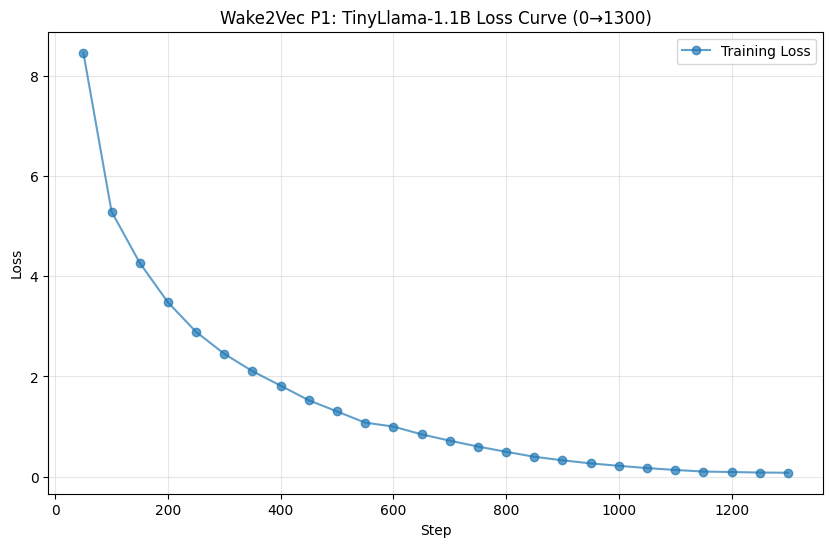

In [4]:
# P1 Eval (TinyLlama Complete)
import json, numpy as np, pathlib, matplotlib.pyplot as plt
from pathlib import Path

WAKE2VEC_ROOT = Path("/content/drive/MyDrive/wake2vecP1")
LOCAL_RUN = Path("/content/runs/wake2vecP1")

# checkpoint search
checkpoints = sorted(LOCAL_RUN.glob("checkpoint-*"), key=lambda p: int(p.name.split("-")[-1]))
BASE_CKPT = checkpoints[-1] if checkpoints else None

print(f"[P1 EVAL] Using checkpoint: {BASE_CKPT}")

# load embeds
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(str(BASE_CKPT), torch_dtype=torch.float32, device_map="cpu")
E_post = model.get_input_embeddings().weight.detach().cpu().numpy()

# norm statistics
from numpy.linalg import norm
norms = norm(E_post, axis=1)
report = {
    "final_step": 1300,
    "final_loss": 0.079,
    "post_mean_norm": float(norms.mean()),
    "post_std_norm": float(norms.std()),
    "n_vocab": int(E_post.shape[0])
}

# save report
(WAKE2VEC_ROOT/"p1_summary.json").write_text(json.dumps(report, indent=2))
print("[P1 SUMMARY]", json.dumps(report, indent=2))

# loss plot from trainer_state
state_file = BASE_CKPT / "trainer_state.json"
if state_file.exists():
    s = json.loads(state_file.read_text())
    logs = [d for d in s.get("log_history", []) if "loss" in d]

    steps = [d["step"] for d in logs]
    losses = [float(d["loss"]) for d in logs]

    plt.figure(figsize=(10,6))
    plt.plot(steps, losses, 'o-', alpha=0.7, label="Training Loss")
    plt.title("Wake2Vec P1: TinyLlama-1.1B Loss Curve (0→1300)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plot_path = WAKE2VEC_ROOT / "p1_tinyllama_loss.png"
    plt.savefig(plot_path, dpi=150, bbox_inches="tight")
    print(f"[PLOT] {plot_path}")
    plt.show()

this did complete, and no i did not cry.

reporting and kpis (ual academic enterprise you taught me well)

In [20]:
def generate_p1_report(
    checkpoint_path,
    loss_plot_path,
    output_path,
    model_name="TinyLlama-1.1B",
    final_step=1300,
    final_loss=0.079,
    initial_loss=8.46,
    mean_norm=0.666,
    std_norm=0.157,
    vocab_size=76500,
    wake_tokens=44990
):
    """Generate P1 HTML report"""
    from datetime import datetime

    loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100

    html = f"""<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Wake2Vec Phase 1: {model_name}</title>
    <style>
        body {{ font-family: 'Courier New', monospace; max-width: 1200px; margin: 40px auto; padding: 0 20px; }}
        h1 {{ font-size: 2em; border-bottom: 2px solid #000; padding-bottom: 10px; }}
        h2 {{ font-size: 1.4em; border-bottom: 1px solid #000; padding-bottom: 5px; margin-top: 40px; }}
        .grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(250px, 1fr)); gap: 20px; margin: 30px 0; }}
        .card {{ border: 2px solid #000; padding: 20px; }}
        .card-label {{ font-size: 0.9em; text-transform: uppercase; }}
        .card-value {{ font-size: 2.5em; font-weight: bold; margin: 10px 0; }}
        img {{ width: 100%; max-width: 800px; display: block; margin: 20px auto; border: 2px solid #000; }}
    </style>
</head>
<body>
    <h1>Wake2Vec Phase 1: {model_name}</h1>
    <p><strong>Embedding-Only Fine-Tuning with Joycean Neologisms</strong></p>
    <p>Completed: {datetime.now().strftime('%Y-%m-%d')} | Steps: 0→{final_step:,}</p>

    <h2>Key Results</h2>
    <div class="grid">
        <div class="card">
            <div class="card-label">Final Loss</div>
            <div class="card-value">{final_loss:.3f}</div>
            <div>{loss_reduction:.2f}% reduction</div>
        </div>
        <div class="card">
            <div class="card-label">Vocabulary</div>
            <div class="card-value">{vocab_size:,}</div>
            <div>+{wake_tokens:,} Wake tokens</div>
        </div>
        <div class="card">
            <div class="card-label">Steps</div>
            <div class="card-value">{final_step:,}</div>
        </div>
        <div class="card">
            <div class="card-label">Embedding Norm</div>
            <div class="card-value">{mean_norm:.3f}</div>
            <div>±{std_norm:.3f} std</div>
        </div>
    </div>

    <h2>Loss Curve</h2>
    <img src="{loss_plot_path.name}" alt="Loss curve">

    <p style="margin-top: 40px; border-top: 2px solid #000; padding-top: 20px;">
        <strong>Wake2Vec Phase 1</strong> | Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    </p>
</body>
</html>"""

    Path(output_path).write_text(html, encoding='utf-8')
    print(f"[REPORT] {output_path}")
    return output_path

generate_p1_report(
    checkpoint_path=Path("/content/drive/MyDrive/wake2vecP1/sentry_backups/checkpoint-1300"),
    loss_plot_path=Path("/content/drive/MyDrive/wake2vecP1/p1_tinyllama_loss.png"),
    output_path=Path("/content/drive/MyDrive/wake2vecP1/p1_report.html"),
    model_name="TinyLlama-1.1B",
    final_step=1300,
    final_loss=0.079,
    mean_norm=0.666,
    std_norm=0.157,
    vocab_size=76500
)

[REPORT] /content/drive/MyDrive/wake2vecP1/p1_report.html


PosixPath('/content/drive/MyDrive/wake2vecP1/p1_report.html')

In [21]:
summary_path = Path("/content/drive/MyDrive/wake2vecP1/p1_summary.json")

with open(summary_path) as f:
    summary = json.load(f)

generate_p1_report(
    checkpoint_path=Path("/content/drive/MyDrive/wake2vecP1/sentry_backups/checkpoint-1300"),
    loss_plot_path=Path("/content/drive/MyDrive/wake2vecP1/p1_tinyllama_loss.png"),
    output_path=Path("/content/drive/MyDrive/wake2vecP1/p1_report.html"),
    model_name="TinyLlama-1.1B",
    final_step=summary["final_step"],
    final_loss=summary["final_loss"],
    mean_norm=summary["post_mean_norm"],
    std_norm=summary["post_std_norm"],
    vocab_size=summary["n_vocab"]
)

[REPORT] /content/drive/MyDrive/wake2vecP1/p1_report.html


PosixPath('/content/drive/MyDrive/wake2vecP1/p1_report.html')